In [191]:
# import the necessary packages
from __future__ import print_function
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import datasets
from skimage import exposure
import numpy as np
#import imutils
import cv2
import matplotlib.pyplot as plt
from mlxtend.data import loadlocal_mnist
from PIL import Image
import random
import os
from urllib.parse import urlparse
import urllib.request
import shutil
import gzip
from pathlib import Path
import skimage.morphology
from skimage.morphology import closing,skeletonize,dilation
from skimage.util import invert
import scipy.ndimage
from scipy.ndimage import maximum_filter
from matplotlib.ticker import PercentFormatter
from scipy.spatial.distance import cdist
import time

project_path = '/Users/lukaszberwid/Digit Recognition Project'

In [ ]:
from sklearn import datasets
mnist = datasets.load_digits()

The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

Each image has size 28x28

In [ ]:
def DownloadData(url):
    a = urlparse(url)
    filename = os.path.basename(a.path)
    filename = os.path.join(project_path, filename)
    urllib.request.urlretrieve(url, filename)
    Ungz(filename)


def Ungz(filename):
    res = os.path.join(project_path, Path(filename).stem)
    with gzip.open(filename, 'rb') as f_in:
        with open(res, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
                
urls = ['http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
      'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
      'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
      'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz']

#for url in urls: 
#    DownloadData(url)

In [9]:
def ValueDistributionHistogram(lab, title):    
    y = np.bincount(lab)
    plt.hist(x=lab)
    plt.axis([min(lab), max(lab), min(y)*0.9, max(y)*1.1])
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(title)
    
def SaveValueDistributionHistogram(lab, title, fileName):    
    y = np.bincount(lab)
    plt.hist(x=lab)
    plt.axis([min(lab), max(lab), min(y)*0.9, max(y)*1.1])
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(title)
    path = os.path.join(project_path, fileName)
    plt.savefig(path)
    
def ConvertToMatrix(array, size):
    return np.reshape(array, (size, size));
    
def Show(array, label):
    n = 28
    plt.imshow(np.reshape(array, (n, n)))
    if label:
        plt.annotate(label,(25,25),bbox={'facecolor':'white'},fontsize=16)

def ShowMatrix(array):
    n = 28
    w,h = 5,5
    fig, axes = plt.subplots(w,h, figsize=(10,10))
    for i,ax in enumerate(axes.flat):
        ax.imshow(np.reshape(array[i], (n, n)))
        
def SaveMatrix(array, fileName):
    n = 28
    w,h = 5,5
    fig, axes = plt.subplots(w,h, figsize=(10,10))
    for i,ax in enumerate(axes.flat):
        ax.imshow(np.reshape(array[i], (n, n)))
    path = os.path.join(project_path, fileName)
    fig.savefig(path)
    

In [212]:
trainData, trainLabels = loadlocal_mnist(
        images_path=os.path.join(project_path, 'train-images-idx3-ubyte'), 
        labels_path=os.path.join(project_path, 'train-labels-idx1-ubyte'))

testData, testLabels = loadlocal_mnist(
        images_path=os.path.join(project_path, 't10k-images-idx3-ubyte'), 
        labels_path=os.path.join(project_path, 't10k-labels-idx1-ubyte'))

In [213]:
#downsize dataset to increase performance, take just 10% percent
factor = 0.2
(_, trainData, _, trainLabels) = train_test_split(trainData, trainLabels, test_size=factor)
(_, testData, _, testLabels) = train_test_split(testData, testLabels, test_size=factor)

In [96]:
skeletionize_maximum = []
skeletonize_dilation = []
threshold = []
for i in range(0, len(trainData)):
    threshold.append([])
    for j in range(0, len(trainData[i])):
        if trainData[i][j] > 100:
            threshold[i].append(1)
        else:
            threshold[i].append(0)
    matrix = ConvertToMatrix(threshold[i],28)
    flt = maximum_filter(matrix, 2)
    skeletionize_maximum.append(closing(skeletonize(flt)))
    flt = dilation(matrix)
    skeletonize_dilation.append(closing(skeletonize(flt)))

# ShowMatrix(threshold)
# ShowMatrix(skeletonize_dilation)
# ShowMatrix(skeletionize_maximum)

In [97]:
trainData = [np.array(n).flatten() for n in skeletonize_dilation]
# trainData = skeletionize_maximum

In [ ]:
ValueDistributionHistogram(trainLabels, 'Training set distribution \nTotal number of values:' + str(len(trainLabels)))

In [ ]:
SValueDistributionHistogram(testLabels, 'Test set distribution \nTotal number of values:' + str(len(testLabels)))

In [206]:
validation_size = 0.1
(trainData, valData, trainLabels, valLabels) = train_test_split(trainData, trainLabels, test_size=validation_size)
print("Training data points: \t{}".format(len(trainLabels)))
print("Validation data points:  {}".format(len(valLabels)))
print("Testing data points: \t{}".format(len(testLabels)))

Training data points: 	10800
Validation data points:  1200
Testing data points: 	2000


In [207]:
factor = 0.09
r = range(1, 20)
data_size_score = []
x = []
ks = []
val_size = []
val_time = []


for i in r:
    (trainData, _, trainLabels, _) = train_test_split(trainData, trainLabels, test_size=factor)
    scores = []
    times = []
    st = time.time()
    for j in range(1, 10):
        knn = KNeighborsClassifier(n_neighbors=j)
        knn.fit(trainData, trainLabels)
        score = knn.score(testData, testLabels);
        scores.append(score)
        times.append(time.time() - st)
        st = time.time()
        print('iter:' + str(i) + ' k:' + str(j))
    data_size_score.append(max(scores))
    ks.append(np.argmax(scores) + 1)
    x.append(len(trainData))
    val_size.append(len(valData))
    val_time.append(np.mean(times))

iter:1 k:1
iter:1 k:2
iter:1 k:3
iter:1 k:4
iter:1 k:5
iter:1 k:6
iter:1 k:7
iter:1 k:8
iter:1 k:9
iter:2 k:1
iter:2 k:2
iter:2 k:3
iter:2 k:4
iter:2 k:5
iter:2 k:6
iter:2 k:7
iter:2 k:8
iter:2 k:9
iter:3 k:1
iter:3 k:2
iter:3 k:3
iter:3 k:4
iter:3 k:5
iter:3 k:6
iter:3 k:7
iter:3 k:8
iter:3 k:9
iter:4 k:1
iter:4 k:2
iter:4 k:3
iter:4 k:4
iter:4 k:5
iter:4 k:6
iter:4 k:7
iter:4 k:8
iter:4 k:9
iter:5 k:1
iter:5 k:2
iter:5 k:3
iter:5 k:4
iter:5 k:5
iter:5 k:6
iter:5 k:7
iter:5 k:8
iter:5 k:9
iter:6 k:1
iter:6 k:2
iter:6 k:3
iter:6 k:4
iter:6 k:5
iter:6 k:6
iter:6 k:7
iter:6 k:8
iter:6 k:9
iter:7 k:1
iter:7 k:2
iter:7 k:3
iter:7 k:4
iter:7 k:5
iter:7 k:6
iter:7 k:7
iter:7 k:8
iter:7 k:9
iter:8 k:1
iter:8 k:2
iter:8 k:3
iter:8 k:4
iter:8 k:5
iter:8 k:6
iter:8 k:7
iter:8 k:8
iter:8 k:9
iter:9 k:1
iter:9 k:2
iter:9 k:3
iter:9 k:4
iter:9 k:5
iter:9 k:6
iter:9 k:7
iter:9 k:8
iter:9 k:9
iter:10 k:1
iter:10 k:2
iter:10 k:3
iter:10 k:4
iter:10 k:5
iter:10 k:6
iter:10 k:7
iter:10 k:8
iter:10 k:9
i

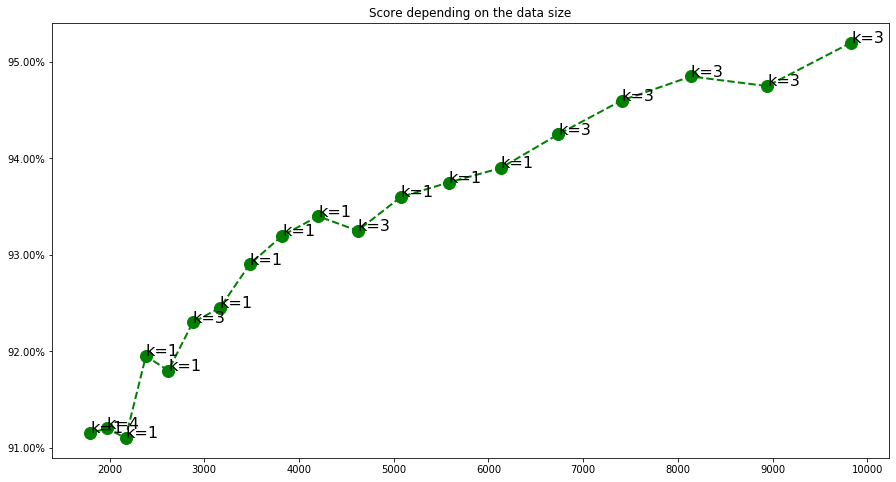

In [209]:
plt.figure(figsize=(15,8))
plt.plot(x, data_size_score, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)

for i in range(0, 19):
    plt.annotate('k=%d' % ks[i], (x[i], data_size_score[i]),fontsize = 16, textcoords='data')
    
plt.title('Score depending on the data size')
# plt.grid(axis='y', alpha=0.75)
# plt.xlabel('Value')
# plt.ylabel('Frequency')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
path = os.path.join(project_path, 'ScoreSize')
plt.savefig(path)

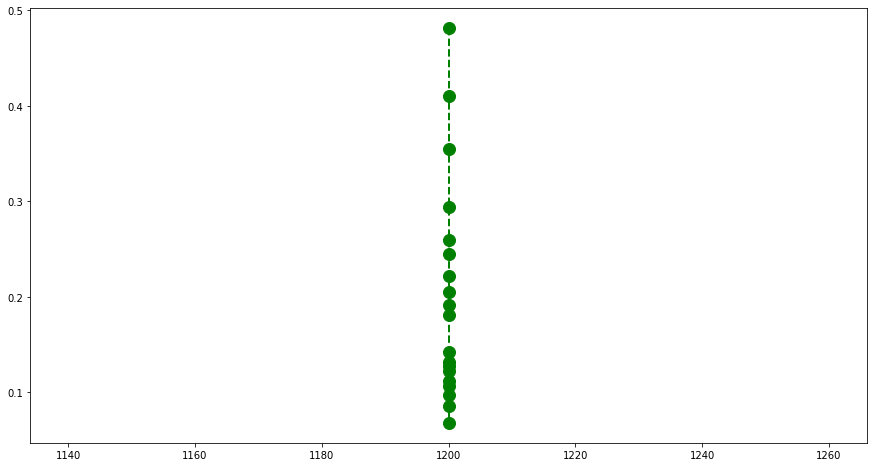

In [210]:
plt.figure(figsize=(15,8))
plt.plot(val_size, [1.0 * n / 60 for n in val_time], color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)

path = os.path.join(project_path, 'TimeSize')
plt.savefig(path)

In [214]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(trainData, trainLabels)
predictions = model.predict(testData)

EVALUATION ON TESTING DATA
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       176
           1       0.92      1.00      0.96       236
           2       0.95      0.96      0.96       211
           3       0.93      0.93      0.93       194
           4       0.95      0.94      0.95       198
           5       0.96      0.95      0.96       198
           6       0.98      0.98      0.98       191
           7       0.93      0.92      0.93       181
           8       0.98      0.91      0.94       200
           9       0.94      0.92      0.93       215

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



In [215]:
print ("Confusion matrix")
print(confusion_matrix(testLabels,predictions))
print('\nClassification report:')
print(classification_report(testLabels,predictions))

Confusion matrix
[[175   0   0   0   0   0   1   0   0   0]
 [  0 235   1   0   0   0   0   0   0   0]
 [  0   4 202   0   0   0   0   3   2   0]
 [  0   0   4 181   1   4   0   3   1   0]
 [  0   2   0   0 187   0   0   0   0   9]
 [  0   1   0   7   1 188   1   0   0   0]
 [  1   1   0   0   0   1 188   0   0   0]
 [  1   9   2   0   1   0   0 167   0   1]
 [  2   0   2   3   5   2   1   2 181   2]
 [  2   4   1   3   2   0   1   4   1 197]]

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       176
           1       0.92      1.00      0.96       236
           2       0.95      0.96      0.96       211
           3       0.93      0.93      0.93       194
           4       0.95      0.94      0.95       198
           5       0.96      0.95      0.96       198
           6       0.98      0.98      0.98       191
           7       0.93      0.92      0.93       181
           8       0.98      0.91      0.

[1063 1566 1724  253 1013  868 1669 1684 1609  960  636  425  811  175
 1855  208]


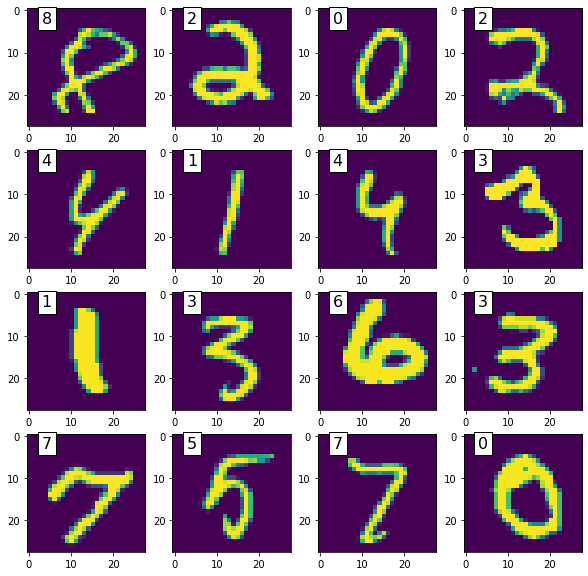

In [231]:
fig, axes = plt.subplots(4,4, figsize=(10,10))
# for i,ax in enumerate(axes.flat):
#     ax.imshow(np.reshape(array[i], (n, n)))

tmp = np.random.randint(0, high=len(testLabels), size=(16,))
print(tmp)
j=0

for i, ax in enumerate(axes.flat):
    # grab the image and classify it
    image = testData[tmp[j]]
    prediction = model.predict([image])[0]
    imgdata = np.array(image, dtype='float')
    pixels = imgdata.reshape((28,28))
    ax.imshow(pixels)
    ax.annotate(prediction,(3,3),bbox={'facecolor':'white'},fontsize=16)
#     print("i think tha digit is : {}".format(prediction))
    j += 1
    
path = os.path.join(project_path, 'Predictions')
plt.savefig(path)